# Data Utility Learning

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import random
from concurrent.futures import as_completed, ProcessPoolExecutor
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm

from valuation.utils import Dataset, Utility, DataUtilityLearning
from valuation.shapley import get_shapley_values

simplefilter("ignore", category=ConvergenceWarning)

In [3]:
plt.rcParams["figure.figsize"] = (18, 12)
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

In [4]:
training_budget_values = np.arange(100, 4000, 100)
random_state = 16

In [ ]:
random.seed(random_state)
np.random.seed(random_state)

In [6]:
X, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=15, random_state=random_state, stratify=y
)
dataset = Dataset(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

In [7]:
model = LinearSVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9185185185185185

In [8]:
utility = Utility(
    model=LinearSVC(),
    data=dataset,
    enable_cache=True,
)

In [9]:
df = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=True,
    enable_cache=True,
)
df = df.rename(columns={"shapley_dval": "exact"})

Index 0:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 1:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 2:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 3:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 4:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 5:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 6:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 7:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 8:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 9:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 10:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 11:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 12:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 13:   0%|          | 0/16384 [00:00<?, ?it/s]

Index 14:   0%|          | 0/16384 [00:00<?, ?it/s]

In [10]:
for training_budget in tqdm(training_budget_values):
    
    def compute_shapley_values(utility: Utility, i: int):
        utility = DataUtilityLearning(
            u=utility,
            training_budget=training_budget,
            model=MLPRegressor(
                hidden_layer_sizes=(20, 10),
                activation='relu',
                solver='adam',
                learning_rate_init=0.001,
                batch_size=32,
                max_iter=800,
            )
        )

        dul_df = get_shapley_values(
            u=utility,
            max_iterations=None,
            mode="combinatorial_exact",
            progress=False,
        )
        dul_df = dul_df.rename(columns={"shapley_dval": f"{training_budget}_{i}"})
        return dul_df
    
    with ProcessPoolExecutor(4) as executor:
        futures = [executor.submit(compute_shapley_values, utility, i) for i in range(10)]
        for future in tqdm(as_completed(futures, timeout=8 * 60), total=10):
            dul_df = future.result()
            df = pd.merge(df, dul_df, on="data_key", suffixes=('', '_delete'))
            df = df[[c for c in df.columns if not c.endswith('_delete')]]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
errors = dict(mean=dict(), min=dict(), max=dict())

for training_budget in tqdm(training_budget_values):
    diffs = [np.linalg.norm(df["exact"] - df[f"{training_budget}_{i}"], ord=1) for i in range(10)]
    errors["mean"][training_budget] = np.mean(diffs)
    errors["min"][training_budget] = np.min(diffs)
    errors["max"][training_budget] = np.max(diffs)

  0%|          | 0/39 [00:00<?, ?it/s]

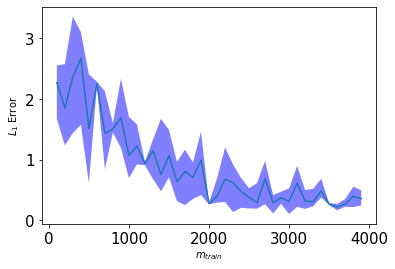

In [13]:
fig, ax = plt.subplots()
ax.plot(errors["mean"].keys(), errors["mean"].values(), label="$L_1$")
ax.fill_between(errors["mean"].keys(), errors["min"].values(), errors["max"].values(), facecolor='blue', alpha=0.5)
ax.set_xlabel("$m_{train}$")
ax.set_ylabel("$L_1$ Error")
plt.show()